In [1]:
import pandas as pd
import keras as ks
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import pickle
from google.colab import drive
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
import warnings
from keras.layers import Conv2D, Flatten, Dropout,MaxPooling2D
from keras.callbacks import History
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from keras.layers import Input
from keras.models import Model

Using TensorFlow backend.


In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
with open("/content/drive/My Drive/Dataset/x_train.obj", 'rb') as x_train:
  x_train = pickle.load(x_train)
with open("/content/drive/My Drive/Dataset/x_test.obj", 'rb') as x_test:
  x_test = pickle.load(x_test)
with open("/content/drive/My Drive/Dataset/y_train.obj", 'rb') as y_train:
  y_train = pickle.load(y_train)

In [4]:
np.bincount(y_train)

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0, 1295, 1265, 1346, 1329, 1336, 1297,
       1269, 1327, 1322, 1321,  893])

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,stratify=y_train, test_size=0.30)

In [0]:
#Data normalization: 
X_train = x_train/255
X_val = x_val/255
X_test = x_test/255

In [0]:
from imblearn.over_sampling import SMOTE
X_train, y_train = SMOTE().fit_resample(X_train.reshape(X_train.shape[0],28*28), y_train)

In [0]:
X_val = X_val.reshape(X_val.shape[0], 28*28)

In [10]:
input_img= Input(shape=(784,))

In [11]:
from keras import regularizers
input_img = Input(shape=(784,))
encoded = Dense(256, activation='relu')(input_img)
encoded = Dense(128, activation='relu')(encoded)
decoded = Dense(784, activation='sigmoid')(encoded)
encoder = Model(input_img, encoded)
decoder = Model(input_img,decoded)

In [12]:
autoencoder = Model(input_img, decoded)
sgd = optimizers.SGD(lr=0.1, decay=1e-4, momentum=0.9, nesterov=True)
autoencoder.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['mae'])
autoencoder.fit(X_train,X_train,
                epochs=100,
                batch_size=512,
                shuffle=False,
                validation_data=(X_val, X_val),verbose = 0)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
encoded_imgs = encoder.predict(X_val)
predicted = autoencoder.predict(X_val)
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               101136    
Total params: 334,992
Trainable params: 334,992
Non-trainable params: 0
_________________________________________________________________


In [14]:
for i in range(11):
  print(np.shape(encoded_imgs[i]))

(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)
(128,)


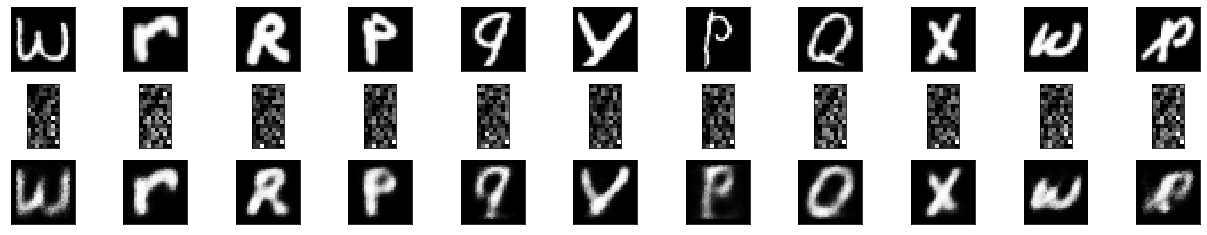

In [15]:
plt.figure(figsize=(40, 4))
for i in range(11):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(X_val[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded image
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoded_imgs[i].reshape(16,8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #display reconstruction
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(predicted[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
plt.show()

In [0]:
input_img= Input(shape=(784,))
def encoder(input_img):
  encoded = Dense(256, activation = 'relu')(input_img)
  encoded = Dense(128, activation='relu')(encoded)
  return encoded

def decoder(encoded):
  decoded = Dense(256, activation='relu')(encoded)
  decoded = Dense(784, activation='sigmoid')(decoded)
  return decoded

In [0]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='binary_crossentropy', optimizer = sgd)

In [18]:
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 784)               201488    
Total params: 468,368
Trainable params: 468,368
Non-trainable params: 0
_________________________________________________________________


In [0]:
autoencoder_train = autoencoder.fit(X_train,X_train,epochs=300,
                batch_size=512,
                shuffle = True,
                validation_data=(X_val, X_val),verbose = 0)

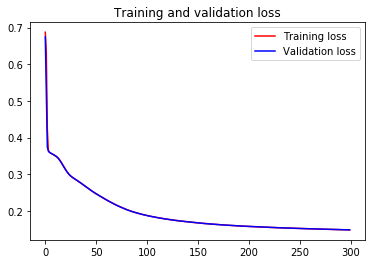

In [20]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(300)
plt.figure()
plt.plot(epochs, loss, 'b', color = 'red', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
autoencoder.save_weights('autoencoder.h5')

In [0]:
encoder_label = LabelEncoder()
encoder_label.fit(y_train)
Y_train = encoder_label.transform(y_train)
dummy_y = np_utils.to_categorical(Y_train)
Y_val = encoder_label.transform(y_val)
dummy_val = np_utils.to_categorical(Y_val)

In [0]:
from keras.regularizers import l1_l2
def fc(enco):
    den = Dense(128, activation='relu',kernel_regularizer=l1_l2(l1 = 0.0001, l2=0.001))(enco)
    den = Dropout(0.3)(den)
    den = Dense(64, activation = 'relu',kernel_regularizer=l1_l2(l1 = 0.001, l2=0.1))(den)
    den = Dropout(0.2)(den)
    out = Dense(11, activation='softmax')(den)
    return out

In [24]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
for l1,l2 in zip(full_model.layers[:2],autoencoder.layers[0:2]):
    l1.set_weights(l2.get_weights())

In [0]:
for layer in full_model.layers[0:2]:
    layer.trainable = False

In [0]:
full_model.compile(loss="categorical_crossentropy", optimizer=sgd,metrics=['accuracy'])

In [82]:
full_model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_29 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_30 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0   

In [0]:
classify_train = full_model.fit(X_train, dummy_y, epochs=150, batch_size=512,validation_data=(X_val,dummy_val), verbose=0)

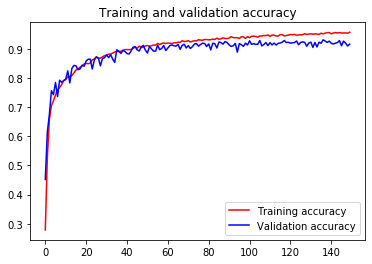

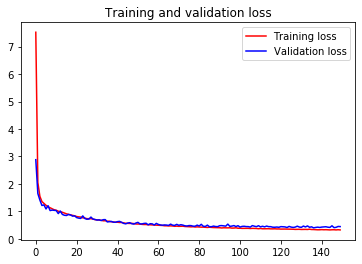

In [84]:
accuracy = classify_train.history['acc']
val_accuracy = classify_train.history['val_acc']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', color = 'red',label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b',color ='red',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [0]:
y_pred_mod2 = full_model.predict(X_val)
print(classification_report(np.argmax(dummy_val, axis = 1), np.argmax(y_pred_mod2, axis = 1)))

In [0]:
full_model.evaluate(X_train,dummy_y)

In [0]:
full_model.evaluate(X_val, dummy_val)

In [0]:
#full_model.save_weights('best_model2_autoencoder.h5')